In [2]:
!pip install CIFAR10

In [3]:
!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
import random

# Scarica e carica il dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Visualizza le dimensioni dei set
print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')


y_train_flat = np.ravel(y_train)
y_train_series = pd.Series(y_train_flat)


print("Distribuzione delle classi (prima):")
print(y_train_series.value_counts())


classi_da_mantenere = y_train_series.value_counts()[y_train_series.value_counts() > 1].index
print("\nClassi da mantenere (con >1 campione):", list(classi_da_mantenere)) 
mask = y_train_series.isin(classi_da_mantenere)
X_train_filtered = X_train[mask]
y_train_filtered = y_train_series[mask]


print("\nDistribuzione delle classi dopo il filtraggio:")
print(y_train_filtered.value_counts())

2025-05-05 15:02:52.482688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746457372.763457      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746457372.836261      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Train set: (50000, 32, 32, 3), (50000, 1)
Test set: (10000, 32, 32, 3), (10000, 1)
Distribuzione delle classi (prima):
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

Classi da mantenere (con >1 campione): [6, 9, 4, 1, 2, 7, 8, 3, 5, 0]

Distribuzione delle classi dopo il filtraggio:
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64


In [5]:
#DIMINUISCO IL DATASET AL 20%
# Calcola il numero di campioni da mantenere (20% del dataset originale)
num_samples_to_keep_train = int(len(X_train) * 0.2)
num_samples_to_keep_test = int(len(X_test) * 0.2)


# Seleziona casualmente gli indici dei campioni da mantenere
indices_to_keep_train = np.random.choice(len(X_train), num_samples_to_keep_train, replace=False)
indices_to_keep_test = np.random.choice(len(X_test), num_samples_to_keep_test, replace=False)

# Crea un sottoinsieme del dataset con gli indici selezionati
X_train_reduced = X_train[indices_to_keep_train]
y_train_reduced = y_train[indices_to_keep_train]
X_test_reduced = X_test[indices_to_keep_test]
y_test_reduced = y_test[indices_to_keep_test]

# Visualizza le dimensioni del set ridotto
print(f'Reduced Train set: {X_train_reduced.shape}, {y_train_reduced.shape}')
print(f'Reduced Test set: {X_test_reduced.shape}, {y_test_reduced.shape}')


Reduced Train set: (10000, 32, 32, 3), (10000, 1)
Reduced Test set: (2000, 32, 32, 3), (2000, 1)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Ridimensiona le immagini in un vettore 1D (flattening)
X_train_flat = X_train_reduced.reshape(X_train_reduced.shape[0], -1)
X_test_flat = X_test_reduced.reshape(X_test_reduced.shape[0], -1)

# Standardizza le caratteristiche (feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print(X_train_scaled.shape )

#divisione del train set in train set e validation set
validation_size = int(0.2 * len(X_train_scaled))
X_validation_split = X_train_scaled[:validation_size]
y_validation_split = y_train_reduced[:validation_size]
X_train_split = X_train_scaled[validation_size:]
y_train_split = y_train_reduced[validation_size:]

# Appiattisci le etichette di training e validation(porto le etichette in 1D)
y_train_split = np.ravel(y_train_split)
y_validation_split = np.ravel(y_validation_split)
y_train_reduced = np.ravel(y_train_reduced)
y_test = np.ravel(y_test)

# Model Selection
validation_scores = {}
test_scores = {}

(10000, 3072)


In [22]:
#k-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


k_value = [3, 5, 7]
best_knn_score = 0
best_k = None

for k in k_value:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_split, y_train_split)
    y_val_pred = knn.predict(X_validation_split)
    score = accuracy_score(y_validation_split, y_val_pred)
    print(f"KNN con k={k}: Accuracy validation = {score}")
    if score > best_knn_score:
        best_knn_score = score
        best_k = k

# Addestra il modello k-NN con il miglior valore di k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train_reduced)

# Valuta il modello sui dati di test
validation_score = accuracy_score(y_validation_split, best_knn.predict(X_validation_split))
test_score = accuracy_score(y_test_reduced, best_knn.predict(X_test_scaled))

print(f"\nMiglior k per KNN: {best_k}")
print(f"Accuracy su validation set: {validation_score}")
print(f"Accuracy su test set: {test_score}")

KNN con k=3: Accuracy validation = 0.2615
KNN con k=5: Accuracy validation = 0.2725
KNN con k=7: Accuracy validation = 0.2815

Miglior k per KNN: 7
Accuracy su validation set: 0.408
Accuracy su test set: 0.2795


In [17]:
#REGRESSIONE LOGISTICA

# Crea il modello di regressione logistica
logistic_model = LogisticRegression(max_iter=1000)

# Addestra il modello sui dati di training ridotti
logistic_model.fit(X_train_split, y_train_split)

# Effettua le previsioni sui dati di validation e test
validation_score = accuracy_score(y_validation_split, logistic_model.predict(X_validation_split))
test_score = accuracy_score(y_test_reduced, logistic_model.predict(X_test_scaled))

print(f"Accuracy on validation set: {validation_score}")
print(f"Accuracy on test set: {test_score}")


Accuracy on validation set: 0.268
Accuracy on test set: 0.2725


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
#SUPPORT VECTOR MACHINE (SVM)
from sklearn import svm

# Crea il modello SVM
svm_model = svm.SVC()

# Addestra il modello sui dati di training ridotti
svm_model.fit(X_train_scaled, y_train_reduced.ravel())

# Calcola l'accuratezza del modello
validation_score = accuracy_score(y_validation_split, svm_model.predict(X_validation_split))
test_score = accuracy_score(y_test_reduced, svm_model.predict(X_test_scaled))

print(f"Accuracy on validation set: {validation_score}")
print(f"Accuracy on test set: {test_score}")

Accuracy on validation set: 0.7185
Accuracy on test set: 0.4775


In [23]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
depth_values = [3, 5, 7, None]
best_dt_score = 0
best_depth = None
for depth in depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    dt.fit(X_train_split, y_train_split)
    y_val_pred = dt.predict(X_validation_split)
    score = accuracy_score(y_validation_split, y_val_pred)
    print(f"Decision Tree con max_depth={depth}: Accuracy validation = {score}")
    if score > best_dt_score:
        best_dt_score = score
        best_depth = depth

# Addestra il miglior Decision Tree
best_dt = DecisionTreeClassifier(max_depth=best_depth, criterion='entropy', random_state=42)
best_dt.fit(X_train_split, y_train_split)

# Calcola l'accuratezza sul set di test
test_accuracy = accuracy_score(y_test_reduced, best_dt.predict(X_test_scaled))
val_accuracy = accuracy_score(y_validation_split, best_dt.predict(X_validation_split))

print(f"Accuracy on test set: {test_accuracy}")
print(f"Accuracy on validation set: {val_accuracy}")


Decision Tree con max_depth=3: Accuracy validation = 0.205
Decision Tree con max_depth=5: Accuracy validation = 0.222
Decision Tree con max_depth=7: Accuracy validation = 0.235
Decision Tree con max_depth=None: Accuracy validation = 0.2135
Accuracy on test set: 0.2535
Accuracy on validation set: 0.235


In [13]:
# Model Selection
validation_scores = {
    "K-NN": best_knn_score,
    "Logistic Regression": validation_score,
    "SVM": validation_score,
    "Decision Tree": best_dt_score
}

test_scores = {
    "K-NN": test_score,
    "Logistic Regression": test_score,
    "SVM": test_score,
    "Decision Tree": test_accuracy
}

print("\nValidation Accuracy per model:")
for model, score in validation_scores.items():
    print(f"{model}: {score:.4f}")

print("\nTest Accuracy per model:")
for model, score in test_scores.items():
    print(f"{model}: {score:.4f}")

best_model = max(test_scores, key=test_scores.get)
print(f"\nBest classifier on test set: {best_model} with accuracy {test_scores[best_model]:.4f}")



Validation Accuracy per model:
K-NN: 0.2815
Logistic Regression: 0.2680
SVM: 0.2680
Decision Tree: 0.2350

Test Accuracy per model:
K-NN: 0.2725
Logistic Regression: 0.2725
SVM: 0.2725
Decision Tree: 0.2535

Best classifier on test set: K-NN with accuracy 0.2725


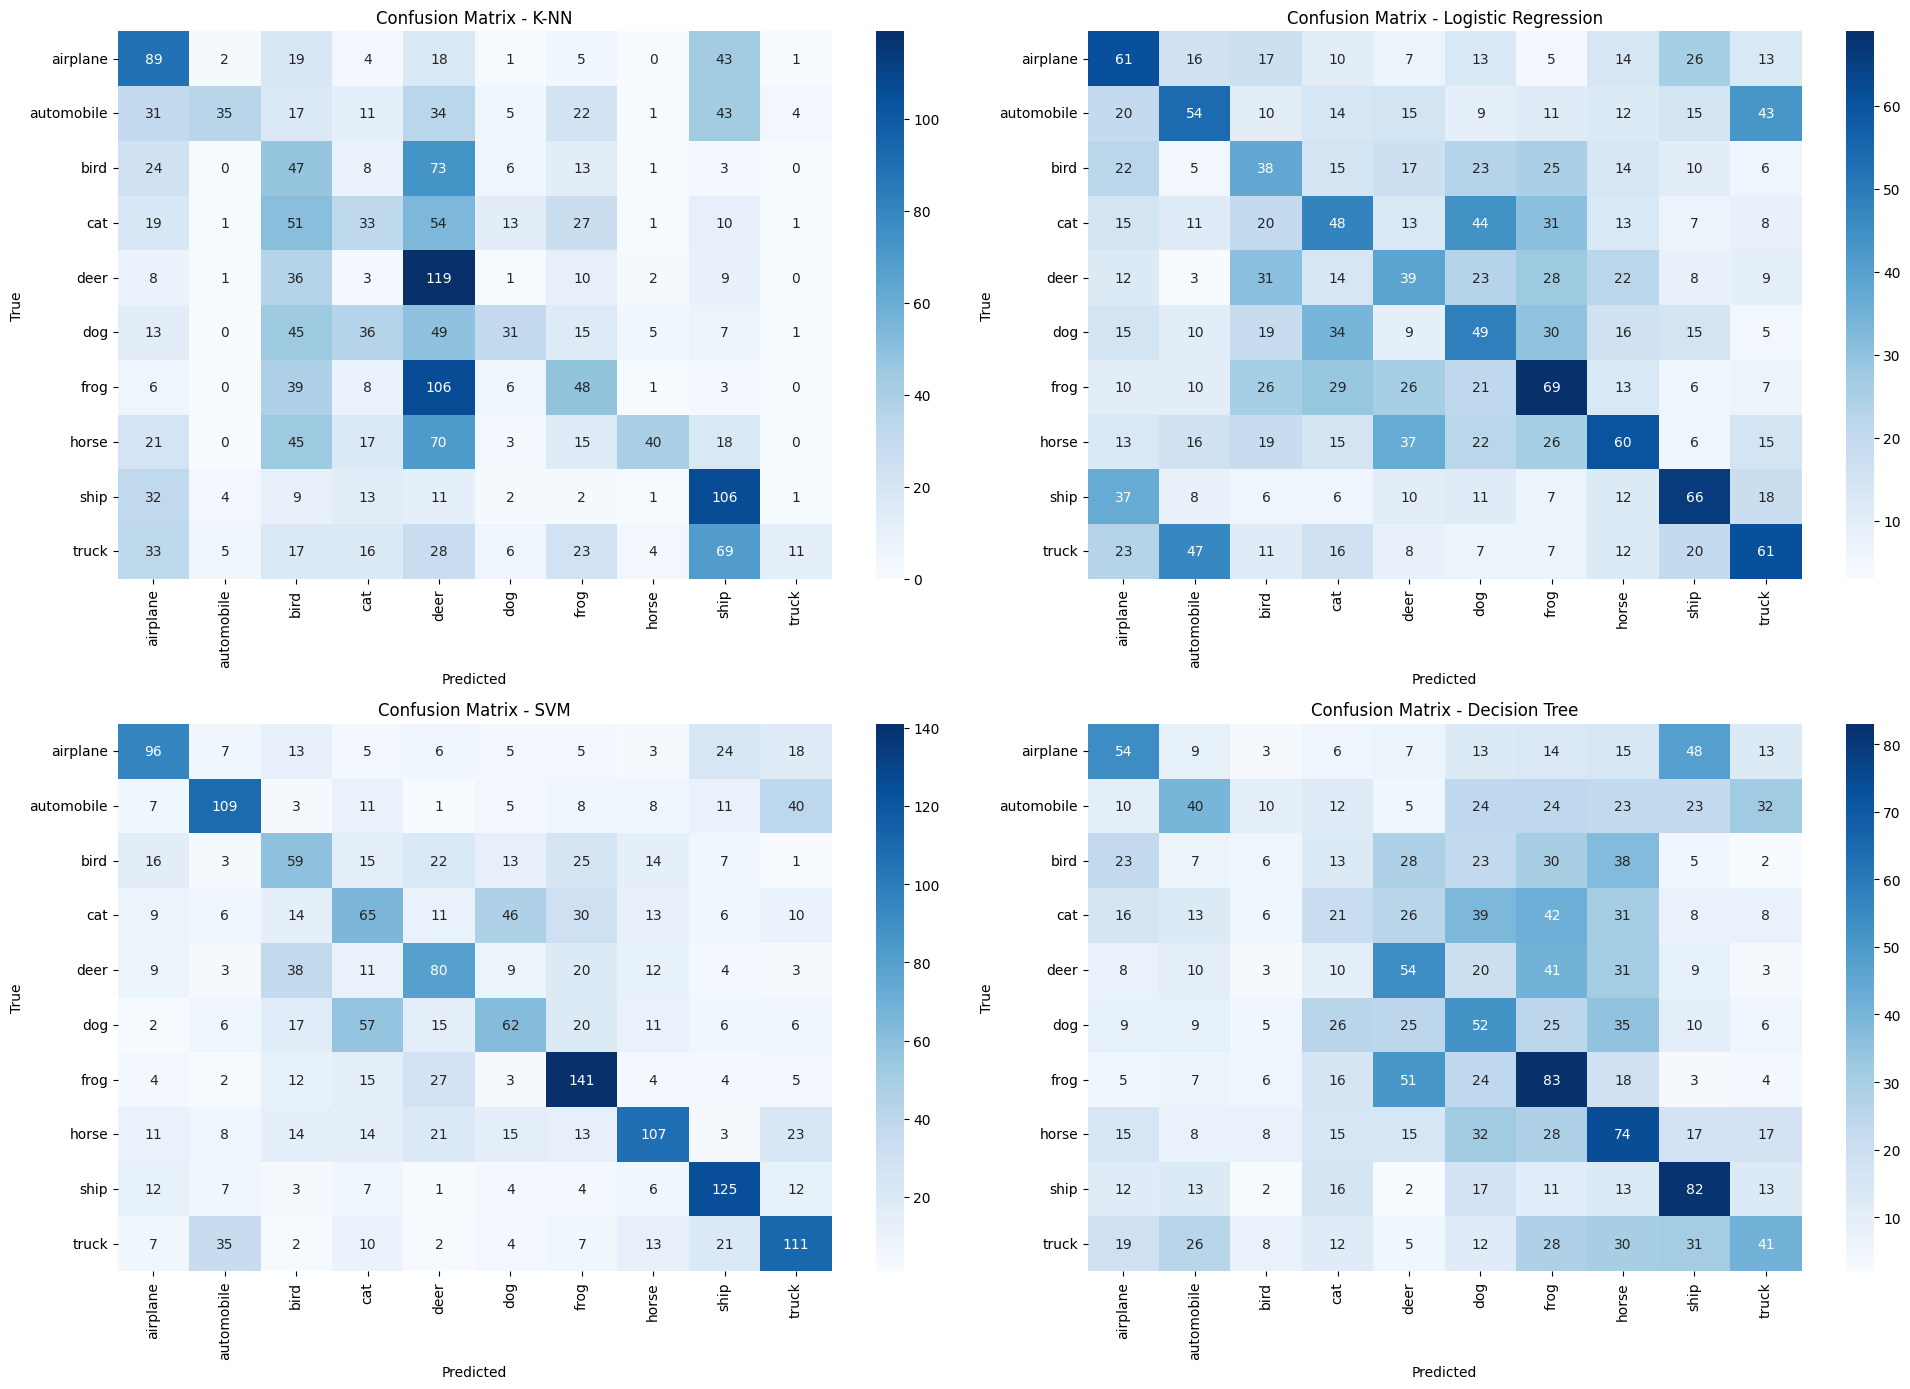

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Classi CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Modelli
models = {
    "K-NN": best_knn,
    "Logistic Regression": logistic_model,
    "SVM": svm_model,
    "Decision Tree": best_dt
}

# Confusion matrix plot
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test_reduced, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()
